In [1]:
!wget -O train.tar.gz https://www.openslr.org/resources/12/train-clean-100.tar.gz

--2021-06-22 10:20:15--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   5.95G  9.24MB/s    in 11m 2s  

2021-06-22 10:31:18 (9.20 MB/s) - ‘train.tar.gz’ saved [6387309499/6387309499]



In [ ]:
!tar -zxvf train.tar.gz

In [2]:
import torch
import torchaudio
import torch.nn.functional as F
import torch.nn as nn
import sys
from torch.autograd import Variable
import math
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import pandas as pd
import glob
import seaborn as sns
import warnings
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
from pathlib import Path
from tqdm.notebook import tqdm
import shutil
from typing import Tuple
import os
import wandb
import pytorch_lightning as pl
from sincnet import *

SEED = 1337
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 256

warnings.simplefilter('ignore')

# Data Preparation

## Collect speakers

In [2]:
with open('LibriSpeech/SPEAKERS.TXT', 'r', encoding='utf-8') as f:
    lines = f.read().split(';')[-1].split('\n')[:-1]
    lines = [list(map(lambda x: x.strip(), line.split('|'))) for line in lines]
    lines = [[line[0], line[1], line[2], line[3], line[5]+' '+line[6]] if line[0] == '60' else line for line in lines] # Preproc strange line

In [3]:
speakers = pd.DataFrame(lines[1:], columns=lines[0])
speakers['ID'] = speakers['ID'].astype(int)
speakers['MINUTES'] = speakers['MINUTES'].astype(float)
# As long as we use train-clean-100, we should filter a bit our df
speakers = speakers[speakers['SUBSET'] == 'train-clean-100']

## Collect paths

In [4]:
id2paths = {}
for id in speakers['ID']:
    id2paths[id] = list(filter(lambda x: x[-4:] == 'flac', glob.glob(f'LibriSpeech/train-clean-100/{id}/*/*')))

one2many = []
for id, paths in list(id2paths.items()):
    for path in paths:
        one2many.append([id, path])

ids_df = pd.DataFrame(one2many, columns=['ID', 'PATH'])
speakers = ids_df.merge(speakers, how='left', on='ID')

In [5]:
unq_speakers = list(speakers['NAME'].value_counts().index)
label_encoder = dict(zip(unq_speakers, range(len(unq_speakers))))

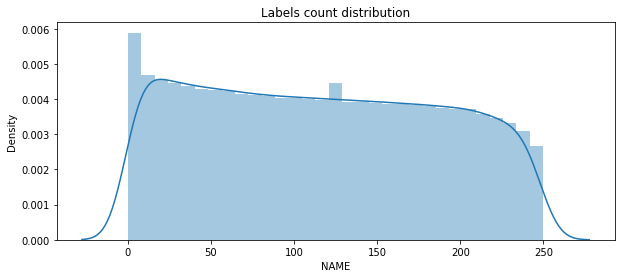

In [6]:
plt.figure(figsize=(10, 4))
plt.title("Labels count distribution")
sns.distplot(speakers['NAME'].map(label_encoder))
plt.show()

In [7]:
speakers

,ID,PATH,SEX,SUBSET,MINUTES,NAME
0,19,LibriSpeech/train-clean-100/19/198/19-198-0000...,F,train-clean-100,25.19,Kara Shallenberg
1,19,LibriSpeech/train-clean-100/19/198/19-198-0020...,F,train-clean-100,25.19,Kara Shallenberg
2,19,LibriSpeech/train-clean-100/19/198/19-198-0001...,F,train-clean-100,25.19,Kara Shallenberg
3,19,LibriSpeech/train-clean-100/19/198/19-198-0035...,F,train-clean-100,25.19,Kara Shallenberg
4,19,LibriSpeech/train-clean-100/19/198/19-198-0021...,F,train-clean-100,25.19,Kara Shallenberg
...,...,...,...,...,...,...
28529,8975,LibriSpeech/train-clean-100/8975/270782/8975-2...,F,train-clean-100,25.11,Daisy Flaim
28530,8975,LibriSpeech/train-clean-100/8975/270782/8975-2...,F,train-clean-100,25.11,Daisy Flaim
28531,8975,LibriSpeech/train-clean-100/8975/270782/8975-2...,F,train-clean-100,25.11,Daisy Flaim
28532,8975,LibriSpeech/train-clean-100/8975/270782/8975-2...,F,train-clean-100,25.11,Daisy Flaim


## Data Preprocessing

In [8]:
# As long as in original paper they make 200ms chunks with 10ms overlap from
# original audio file we do the same. We just prepare chunks idx and will 
# process them dinamicly in dataset later
def generate_chunk_idx_and_norm(data: pd.DataFrame, 
                                sample_rate: int) -> pd.DataFrame:
    overlap = int(0.01*sample_rate)
    chunk_size = int(0.2*sample_rate)
    idx_set = {
        "NAME": [],
        "ID": [],
        "CHUNK_START": [],
        "CHUNK_END": [],
        "PATH": []
    }
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        try:
            wf, sr = sf.read(row['PATH'])
        except:
            print('Smth wrong with file!')
            continue
        if sr != sample_rate:
            print('Smth wrong!')
        if len(wf.shape) == 1:
            wf = wf.reshape(1, -1)
        for i in range(int(overlap), wf.shape[1], int(chunk_size-overlap)):
            if i+chunk_size-overlap >= wf.shape[1]:
                break
            idx_set['NAME'].append(row['NAME'])
            idx_set['ID'].append(row['ID'])
            idx_set['PATH'].append(row['PATH'])
            idx_set['CHUNK_START'].append(i-overlap)
            idx_set['CHUNK_END'].append(i+chunk_size-overlap)
        os.remove(row['PATH'])
        sf.write(row['PATH'], (wf/np.max(np.abs(wf))).reshape(-1), sample_rate)
    return pd.DataFrame(idx_set)

In [9]:
idx_set = generate_chunk_idx_and_norm(speakers, 16000)

Smth wrong with file!



## Label Processing
Convert strings to labels

In [10]:
label_encoder = dict(zip(list(idx_set['NAME'].unique()), range(idx_set['NAME'].unique().shape[0])))
inverse_label_encoder = dict(zip(range(idx_set['NAME'].unique().shape[0]), list(idx_set['NAME'].unique())))

In [11]:
idx_set['NAME'] = idx_set['NAME'].map(label_encoder)

## Train/Test split

In [12]:
# Following the SincNet paper we should choose 12-15s audios for train set
# and 2-6s audios for test set
def train_test_split(data: pd.DataFrame) -> Tuple[pd.DataFrame]:
    new_data = data[['ID', 'PATH']].drop_duplicates(['ID', 'PATH'])\
                .reset_index(drop=True)
    train_samples = {k:[] for k in ['ID', 'PATH']}
    test_samples = {k:[] for k in ['ID', 'PATH']}

    for _, row in tqdm(new_data.iterrows(), total=new_data.shape[0]):
        info = torchaudio.info(row['PATH'])
        duration = info.num_frames/info.sample_rate
        if 2 <= duration <= 6:
            test_samples['ID'].append(row['ID'])
            test_samples['PATH'].append(row['PATH'])
        elif 12 <= duration <= 15:
            train_samples['ID'].append(row['ID'])
            train_samples['PATH'].append(row['PATH'])

    train_samples = data[(data['ID'].isin(train_samples['ID']))&(data['PATH'].isin(train_samples['PATH']))]
    test_samples = data[(data['ID'].isin(test_samples['ID']))&(data['PATH'].isin(test_samples['PATH']))]
    return train_samples.reset_index(drop=True), test_samples.reset_index(drop=True)

        

In [13]:
train, test = train_test_split(idx_set)

## Create Dataset

In [14]:
class LibriSpeechDataset(Dataset):
    def __init__(self, data: pd.DataFrame, sample_rate: int = 16000):
        # We need this for CER
        unq_samples = data[['ID', 'PATH']].drop_duplicates(['ID', 'PATH']).values
        unq_samples = list(map(lambda x: (x[0], x[1]), list(unq_samples)))
        d = dict(zip(unq_samples, range(len(unq_samples))))
        data['SAMPLE_ID'] = data.apply(lambda row: d[(row['ID'], row['PATH'])], axis=1)
        self.data = data
         
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        frames_num = int(sample['CHUNK_END']-sample['CHUNK_START'])
        wf, sr = torchaudio.load(sample['PATH'], 
                                 frame_offset=sample['CHUNK_START'],
                                 num_frames=frames_num)
        return {
            'audios': wf,
            'labels': sample['NAME'],
            'sample_ids': sample['SAMPLE_ID']
        }

In [15]:
train_dataset = LibriSpeechDataset(train)
test_dataset = LibriSpeechDataset(test)

train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                      shuffle=True, num_workers=4)
test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, 
                      shuffle=False, num_workers=4)

# Model

## Architecture

In [4]:
from model import SincNet

## Train and validate

In [17]:
wandb.login()

wandb: Currently logged in as: sheminy32 (use `wandb login --relogin` to force relogin)


True

In [21]:
model

SincNet(
  (cnn): Sequential(
    (0): LayerNorm((1, 3200), eps=1e-06, elementwise_affine=True)
    (1): SincConv_fast()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): LayerNorm((80, 983), eps=1e-06, elementwise_affine=True)
    (4): ReLU()
    (5): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
    (6): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): LayerNorm((60, 326), eps=1e-06, elementwise_affine=True)
    (8): ReLU()
    (9): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    (10): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (11): LayerNorm((60, 107), eps=1e-06, elementwise_affine=True)
    (12): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=6420, out_features=2048, bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=2048, out_features=

In [22]:
config = {
    "n_class": len(label_encoder),
    "sample_rate": 16000,
    "input_shape": (1, 3200),
    "use_wandb": True
}
for optimizer in ["rmsprop", "sgd", "adam"]:
    for first_conv in ["sinc", "base"]:
        
        config['optimizer'] = optimizer
        config['first_conv'] = first_conv
        
        name = f"cnn-{optimizer}" if first_conv == 'base' else f"{first_conv}-{optimizer}"
        wandb.init(project="sincnet-exp", entity="sheminy32", config=config, id=name)
        
        pl.seed_everything(SEED)

        cb = pl.callbacks.ModelCheckpoint(
            dirpath='models/',
            filename=name+'-{epoch}-{val_cer:.2f}-{val_fer(%):.2f}.ckp',
            monitor="val_cer",
            mode="min"
        )

        model = SincNet(config)
        trainer = pl.Trainer(gpus=1, max_epochs=10, callbacks=[cb])
        trainer.fit(model, train_dl, test_dl)
        wandb.finish()

Global seed set to 1337
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | cnn     | Sequential       | 277 K 
1 | mlp     | Sequential       | 22.1 M
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
89.365    Total estimated model params size (MB)


Global seed set to 1337


wandb: Network error resolved after 0:00:38.503127, resuming normal operation.


val_loss/step,0.75601
val_fer(%)/step,23.01587
_runtime,7087
_timestamp,1624434830
_step,73172
val_loss/epoch,0.79385
val_fer(%)/epoch,20.86795
val_cer,0.23613
train_loss/step,0.30462
train_fer(%)/step,9.375
train_loss/epoch,0.30837


val_loss/step,▆▅▆▇▅▅▃▅▅▅▄▄▄▄▃▃▃▆▃▆▅▂▄▂▃▂▁█▃▄▂▃▄▄▃▂▂▁▃▄
val_fer(%)/step,█▇▇█▅▅▃▆▇▆▅▅▅▄▃▄▃▇▃▆▆▂▅▂▃▂▁█▄▄▂▂▄▅▃▂▂▁▃▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss/epoch,█▃▂▂▁▁▁▁▁▁▁
val_fer(%)/epoch,█▃▃▂▂▂▁▁▁▁▁
val_cer,█▂▂▁▁▁▁▁▁▁▁
train_loss/step,█▇▅▅▄▄▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂
train_fer(%)/step,█▇▅▅▄▄▄▄▄▃▃▄▃▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▂
train_loss/epoch,█▄▃▃▂▂▂▁▁▁
